In [1]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import matplotlib.pyplot as plt
from rasterio import features
from affine import Affine

import FINE as fn
import FINE.spagat.dataset as spd
import FINE.spagat.representation as spr 
import FINE.IOManagement.xarray_io as xrio 

# Data and Shapefile

#### Gridded test data 

In [2]:
time_steps = 10
x_coordinates = 5
y_coordinates = 3

time = np.arange(time_steps)
x_locations = [1, 2, 3, 4, 5]
y_locations = [1, 2, 3]

In [8]:
#capacity factor time series 
test_data = np.zeros((x_coordinates, y_coordinates, time_steps))

test_capfac_dataarray = xr.DataArray(test_data, 
                                     coords=[x_locations, y_locations, time], 
                                     dims=['x', 'y','time'])

#first region - 9 time series, x_coords:0,1,2, y_coords: 0,1,2
first_region_data, first_region_labels = make_blobs(n_samples = 9, 
                                                   centers = 4, 
                                                   n_features = time_steps, 
                                                   random_state = 0)  #, center_box=(0, 1)

first_region_data = first_region_data.reshape(3,3,10)

for i, x_location in enumerate(x_locations[:3]):
    test_capfac_dataarray.loc[x_location,:,:] = first_region_data[i, :,:]
    
#second region - 6 time series, x_coords:3,4, y_coords: 0,1,2
second_region_data, second_region_labels = make_blobs(n_samples = 6, 
                                                   centers = 2, 
                                                   n_features = time_steps, 
                                                   random_state = 0)  #, center_box=(0, 1)

second_region_data = second_region_data.reshape(2,3,10)

for i, x_location in enumerate(x_locations[3:]):
    test_capfac_dataarray.loc[x_location,:,:] = second_region_data[i, :,:]

In [13]:
#capacities
test_data = np.ones((x_coordinates, y_coordinates))
test_capacity_dataarray = xr.DataArray(test_data, 
                                       coords=[x_locations, y_locations], 
                                       dims=['x', 'y'])
    

In [14]:
test_Dataset = xr.Dataset({'capacity': test_capacity_dataarray,
                            'capfac': test_capfac_dataarray}) 
test_Dataset

<xarray.Dataset>
Dimensions:   (time: 10, x: 5, y: 3)
Coordinates:
  * x         (x) int32 1 2 3 4 5
  * y         (y) int32 1 2 3
  * time      (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity  (x, y) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    capfac    (x, y, time) float64 0.08848 2.323 1.707 ... 7.093 11.54 -3.786

#### test shapefile 

In [15]:
polygon1 = Polygon([(0,0), (4,0), (4,4), (0,4)])
polygon2 = Polygon([(4,0), (7,0), (7,4), (4,4)])

test_geometries = [MultiPolygon([polygon1]),
                   MultiPolygon([polygon2])] 

df = pd.DataFrame({'region_ids': ['reg_01', 'reg_02']})

gdf = gpd.GeoDataFrame(df, geometry=test_geometries, crs=f'epsg:{3035}') 

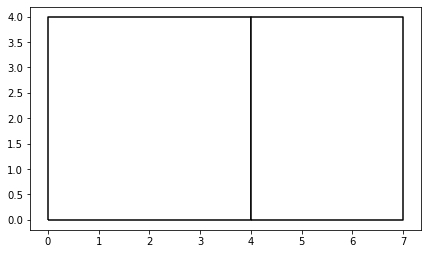

In [16]:
gdf.plot(figsize=(7, 7), color='white', edgecolor='black', linewidth = 1.5)

TEST_SHP_PATH = 'C:/Users/s.patil/Documents/code/fine/experiments/REPRESENTATION/InputData/Shapefiles'

gdf.to_file(TEST_SHP_PATH, layer = 'test_shp_representation') 

# Functions to convert girdded data into regional data based on given shapefile

In [20]:
def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

In [21]:
def rasterize_geometry(geometry, coords, latitude='y', longitude='x'):
    
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    
    raster = features.rasterize([geometry], 
                                out_shape=out_shape,
                                fill=np.nan, 
                                transform=transform,
                                dtype=float)
    

    return raster 

In [22]:
def add_shapes_from_shp(sds, 
                        shp_path, 
                        index_col='region_ids', 
                        geometry_col='geometry',
                        longitude='x', 
                        latitude='y'):

    #STEP 1. Read shapefile
    regions_shp = gpd.read_file(shp_path)
    
    #STEP 2. Add geometries 
    region_geometries = regions_shp[geometry_col]
    region_indices = regions_shp[index_col]
    
#     if not region_description:
#         region_description = index_col
        

    sds.xr_dataset = sds.xr_dataset.expand_dims(region_ids = region_indices) # TODO: check how to take region_description from the user and pass it here 
    
        
#     sds.add_objects(description="gpd_geometries",
#                     dimension_list=[region_description],
#                     object_list=region_geometries)
    

    # 2. rasterize each geometry and add it to new data_var "rasters"
    coords = sds.xr_dataset.coords 
    
    sds.xr_dataset['rasters'] = ([index_col, 'y', 'x'],
                                      [rasterize_geometry(geometry, 
                                                 coords, 
                                                 longitude=longitude, 
                                                 latitude=latitude)
                                       for geometry in regions_shp[geometry_col]])
    return sds

# Usage 

In [17]:
sds = spd.SpagatDataset()

sds.xr_dataset = test_Dataset

In [18]:
TEST_SHP_PATH = 'C:/Users/s.patil/Documents/code/fine/experiments/REPRESENTATION/InputData/Shapefiles/test_shp_representation.shp'

In [23]:
regional_sds = add_shapes_from_shp(sds, 
                                TEST_SHP_PATH, 
                                index_col='region_ids', 
                                geometry_col='geometry',
                                longitude='x', 
                                latitude='y')

In [24]:
regional_sds.xr_dataset

<xarray.Dataset>
Dimensions:     (region_ids: 2, time: 10, x: 5, y: 3)
Coordinates:
  * region_ids  (region_ids) object 'reg_01' 'reg_02'
  * x           (x) int32 1 2 3 4 5
  * y           (y) int32 1 2 3
  * time        (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity    (region_ids, x, y) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    capfac      (region_ids, x, y, time) float64 0.08848 2.323 ... 11.54 -3.786
    rasters     (region_ids, y, x) float64 1.0 1.0 1.0 nan ... nan nan 1.0 1.0

In [25]:
subset = sds.xr_dataset.where(regional_sds.xr_dataset.rasters[1:]) #Incase you want to send just a subset of regions 

In [32]:
subset 

<xarray.Dataset>
Dimensions:     (region_ids: 1, time: 10, x: 5, y: 3)
Coordinates:
  * region_ids  (region_ids) object 'reg_02'
  * x           (x) int32 1 2 3 4 5
  * y           (y) int32 1 2 3
  * time        (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity    (region_ids, x, y) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    capfac      (region_ids, x, y, time) float64 0.08848 2.323 ... 11.54 -3.786
    rasters     (region_ids, y, x) float64 nan nan nan 1.0 ... nan nan 1.0 1.0

In [30]:
## within the function subsetting one region 
regional_data = subset.where(subset.rasters.sel(region_ids="reg_02"))

In [31]:
regional_data

<xarray.Dataset>
Dimensions:     (region_ids: 1, time: 10, x: 5, y: 3)
Coordinates:
  * region_ids  (region_ids) object 'reg_02'
  * x           (x) int32 1 2 3 4 5
  * y           (y) int32 1 2 3
  * time        (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity    (region_ids, x, y) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    capfac      (region_ids, x, y, time) float64 0.08848 2.323 ... 11.54 -3.786
    rasters     (region_ids, y, x) float64 nan nan nan 1.0 ... nan nan 1.0 1.0

In [35]:
regional_capfac = regional_data.capfac.where(regional_data.rasters == 1)

In [36]:
regional_capfac

<xarray.DataArray 'capfac' (region_ids: 1, x: 5, y: 3, time: 10)>
array([[[[         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan],
         [         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan],
         [         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan],
         [         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan],
         [         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan]],

...

        [[  4.20430241,   1.04068065,   0.45359286,   8.56387816,
           -7.85018827,  -8.1284311 ,  -8.45623137,   5.41757109,
            5.96547666,   6.71543287],
         [  1.0220286 ,   4.11660348,   3.58804674,   2.36702243,
           -1.37195659,   3.29604478,  -2.13604152,   5.85466355,
            8.92534306,  -2.17482065],
         [  5.90101798,   0.88037029,   0.72656913,   8.1491916 ,
           -9.25173928,  -8.61696717, -10.40877833,   4.92611431,
            5.74056116,   6.99846203]],

        [[  2.20656076,   5.50616718,   1.6679407 ,   0.59536091,
           -2.57545698,   1.49786432,  -2.95452597,   9.78623541,
            8.76360303,  -2.76924393],
         [  4.5817054 ,   1.35538875,  -0.25300663,   8.29919249,
           -9.4747454 ,  -7.87051151, -10.10643719,   5.47176473,
            5.53495279,   7.82857484],
         [  2.47034915,   4.09862906,   2.36833522,   0.04356792,
           -4.07989383,   3.57150086,  -0.38381958,   7.093295  ,
           11.54300983,  -3.7855353 ]]]])
Coordinates:
  * region_ids  (region_ids) object 'reg_02'
  * x           (x) int32 1 2 3 4 5
  * y           (y) int32 1 2 3
  * time        (time) int32 0 1 2 3 4 5 6 7 8 9

In [37]:
regional_capacity = regional_data.capacity.where(regional_data.rasters == 1)

In [38]:
regional_capacity

<xarray.DataArray 'capacity' (region_ids: 1, x: 5, y: 3)>
array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]]])
Coordinates:
  * region_ids  (region_ids) object 'reg_02'
  * x           (x) int32 1 2 3 4 5
  * y           (y) int32 1 2 3